## Breaking Captchas using Keras CNN

In [1]:
# Imports
import numpy as np
import os
import pickle

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta
from matplotlib import pyplot as plt
from PIL import Image
import cv2

%matplotlib inline

/home/yan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
'''# resize img

train_dir_raw = r'/home/yan/jupyter notebooks/a'
train_dir = r'/home/yan/jupyter notebooks/train_dir'


for item in os.listdir(train_dir_raw):
    img_raw = Image.open(train_dir_raw + '/' + item)
    width, height = img_raw.size
    left = 5
    top = 5
    right = width*0.42
    bottom = height*0.9
    img_output = img_raw.crop((left, top, right, bottom))
    img_output.save(train_dir + '/' + item)'''

In [3]:
'''train_dir_raw = r'/home/yan/jupyter notebooks/b'
train_dir = r'/home/yan/jupyter notebooks/c'


for item in os.listdir(train_dir_raw):
    a = cv2.imread(train_dir_raw + '/' + item,cv2.COLOR_GRAY2RGB)
    cv2.imwrite(train_dir + '/' + item,a)'''

"train_dir_raw = r'/home/yan/jupyter notebooks/b'\ntrain_dir = r'/home/yan/jupyter notebooks/c'\n\n\nfor item in os.listdir(train_dir_raw):\n    a = cv2.imread(train_dir_raw + '/' + item,cv2.COLOR_GRAY2RGB)\n    cv2.imwrite(train_dir + '/' + item,a)"

In [4]:
'''img_path = r'/home/yan/jupyter notebooks/c/RSFSY.png'


img = Image.open(img_path)
print (img.size)'''

"img_path = r'/home/yan/jupyter notebooks/c/RSFSY.png'\n\n\nimg = Image.open(img_path)\nprint (img.size)"

In [5]:
img_path = r'/home/yan/jupyter notebooks/train_dir/ffnkf.png'


img = Image.open(img_path)
print (img.size)

(235, 50)


In [39]:
# parameters
train_dir = r'/home/yan/jupyter notebooks/train_dir'

captcha_word = "123456789abcdefghijklmnopqrstuvwxyz"
#captcha_word = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

width = 94
height = 40


word_len = 5
word_class = len(captcha_word)


char_indices = dict((c, i) for i,c in enumerate(captcha_word))
indices_char = dict((i, c) for i,c in enumerate(captcha_word))

In [40]:
# useful methods
def captcha_to_vec(captcha):    
    vector = np.zeros(word_len * word_class)
    
    for i,ch in enumerate(captcha):
        idex = i * word_class + char_indices[ch]
        vector[idex] = 1
    return vector

def vec_to_captcha(vec):
    text = []
    vec[vec < 0.5] = 0
        
    char_pos = vec.nonzero()[0]
    
    for i, ch in enumerate(char_pos):
        text.append(captcha_word[ch % word_class])
    return ''.join(text)

test_vec = captcha_to_vec("12345")
vec_test = vec_to_captcha(test_vec)

print(test_vec)
print(vec_test)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
12345


In [41]:
# get image names
image_list = []

i = 0
for item in os.listdir(train_dir):
    image_list.append(item)
    if (i > 1000):
        break
        
    i+=1
    
np.random.shuffle(image_list)
print (image_list[:10])

['eedrx.png', 'aka5b.png', 'c52f4.png', 'cm3bk.png', '8rxkm.png', 'b4c2b.png', '2yrnw.png', '4gcgf.png', '2ba2b.png', 'g5cx8.png']


In [42]:
#load images
X = np.zeros((len(image_list), height, width, 3), dtype = np.uint8)
y = np.zeros((len(image_list), word_len * word_class), dtype = np.uint8)

for i,img in enumerate(image_list):
    if i % 1000 == 0:
        print(i)
    img_path = train_dir + "/" + img
    raw_img = image.load_img(img_path, target_size=(height, width))
    X[i] = image.img_to_array(raw_img)
    y[i] = captcha_to_vec(img.split('.')[0])

0


In [43]:
#pickle
file = open('captcha_train_data.pkl','wb')
pickle.dump((X,y) , file)

file = open('captcha_train_data.pkl', 'rb')
X, y = pickle.load(file)

In [44]:
# Keras CNN (Convolutional Neural Network)
input_tensor = Input(shape=(height, width, 3))

x = input_tensor

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(64, 3, padding='same', activation='relu')(x)
x = Convolution2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(128, 3, padding='same', activation='relu')(x)
x = Convolution2D(128, 3, padding='same',activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

x = [Dense(word_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(word_len)]
output = concatenate(x)

In [45]:
# model
model = Model(inputs=input_tensor, outputs=output)

#model.load_weights('captcha_weights.0.9430.hdf5')

opt = Adadelta(lr=0.1)

model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
checkpointer = ModelCheckpoint(filepath="output/weights.{epoch:02d}--{val_loss:.2f}-{val_acc:.4f}.hdf5", 
                               verbose=2, save_weights_only=True)

model.fit(X, y, epochs=50, callbacks=[checkpointer], validation_split=0.1)

Train on 54 samples, validate on 7 samples
Epoch 1/50
54/54 [==============================] - 2s 41ms/step - loss: 72.3011 - acc: 0.0185 - val_loss: 57.9356 - val_acc: 0.0000e+00

Epoch 00001: saving model to output/weights.01--57.94-0.0000.hdf5
Epoch 2/50
54/54 [==============================] - 1s 27ms/step - loss: 62.0093 - acc: 0.0185 - val_loss: 54.2280 - val_acc: 0.0000e+00

Epoch 00002: saving model to output/weights.02--54.23-0.0000.hdf5
Epoch 3/50
54/54 [==============================] - 2s 33ms/step - loss: 53.8511 - acc: 0.0185 - val_loss: 43.5704 - val_acc: 0.0000e+00

Epoch 00003: saving model to output/weights.03--43.57-0.0000.hdf5
Epoch 4/50
54/54 [==============================] - 2s 33ms/step - loss: 44.3878 - acc: 0.0000e+00 - val_loss: 35.5626 - val_acc: 0.0000e+00

Epoch 00004: saving model to output/weights.04--35.56-0.0000.hdf5
Epoch 5/50
54/54 [==============================] - 1s 25ms/step - loss: 34.8293 - acc: 0.0185 - val_loss: 31.2123 - val_acc: 0.0000e+00


54/54 [==============================] - 2s 34ms/step - loss: 8.2512 - acc: 0.1481 - val_loss: 36.0385 - val_acc: 0.0000e+00

Epoch 00041: saving model to output/weights.41--36.04-0.0000.hdf5
Epoch 42/50
54/54 [==============================] - 2s 32ms/step - loss: 8.2324 - acc: 0.2407 - val_loss: 36.3002 - val_acc: 0.0000e+00

Epoch 00042: saving model to output/weights.42--36.30-0.0000.hdf5
Epoch 43/50
54/54 [==============================] - 2s 32ms/step - loss: 8.2645 - acc: 0.2778 - val_loss: 36.3742 - val_acc: 0.0000e+00

Epoch 00043: saving model to output/weights.43--36.37-0.0000.hdf5
Epoch 44/50
54/54 [==============================] - 2s 38ms/step - loss: 8.2126 - acc: 0.1852 - val_loss: 36.5747 - val_acc: 0.0000e+00

Epoch 00044: saving model to output/weights.44--36.57-0.0000.hdf5
Epoch 45/50
54/54 [==============================] - 2s 33ms/step - loss: 8.2723 - acc: 0.2593 - val_loss: 36.8403 - val_acc: 0.0000e+00

Epoch 00045: saving model to output/weights.45--36.84-0.00

In [46]:
#save results
model.save_weights('output/captcha_model_weights.h5')
model.save('output/captcha__model.h5')

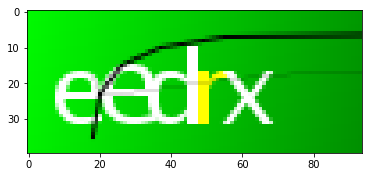

true: eedrx | predicted: a5lvk


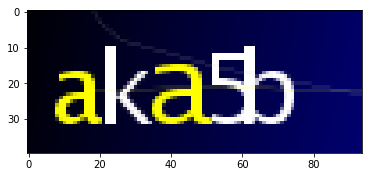

true: aka5b | predicted: acpvf


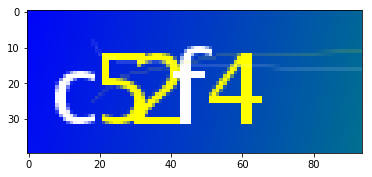

true: c52f4 | predicted: amlvk


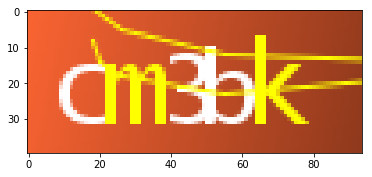

true: cm3bk | predicted: a1pvk


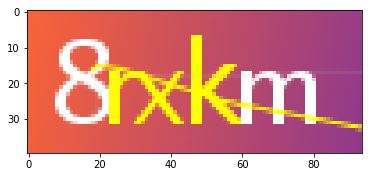

true: 8rxkm | predicted: a1pvk


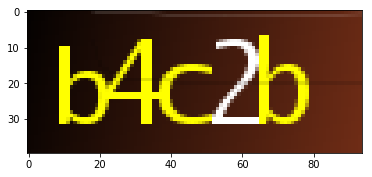

true: b4c2b | predicted: 21lvk


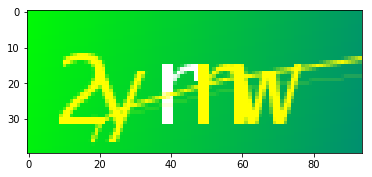

true: 2yrnw | predicted: amlvf


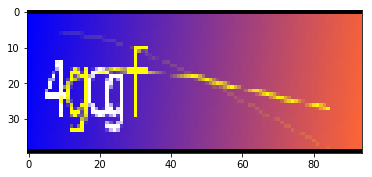

true: 4gcgf | predicted: 2cpvk


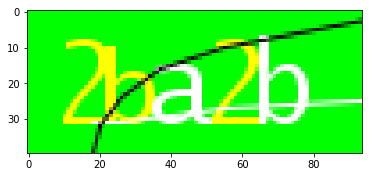

true: 2ba2b | predicted: aclvf


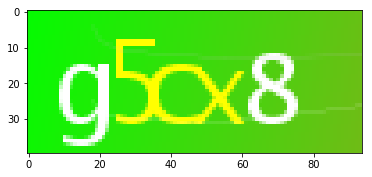

true: g5cx8 | predicted: amlvk


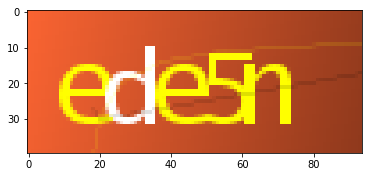

true: ede5n | predicted: 21pvk


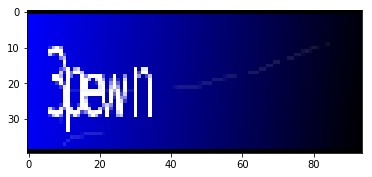

true: 3pewn | predicted: hmevk


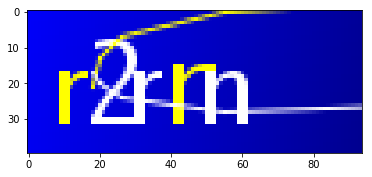

true: r2rrn | predicted: aevk


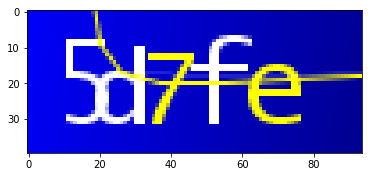

true: 5d7fe | predicted: acev


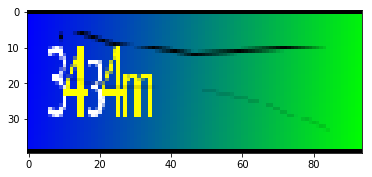

true: 3434m | predicted: amlvk


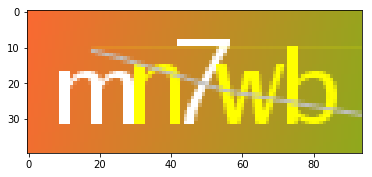

true: mn7wb | predicted: a1pvk


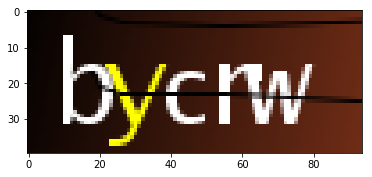

true: bycrw | predicted: 21vf


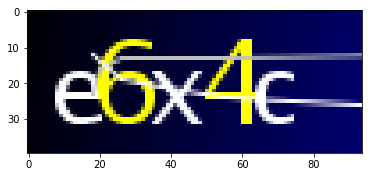

true: e6x4c | predicted: 2l2f


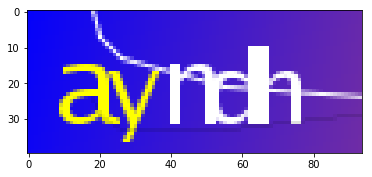

true: ayndh | predicted: 27pvk


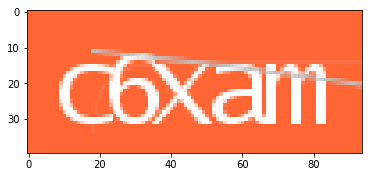

true: c6xam | predicted: a1pvk


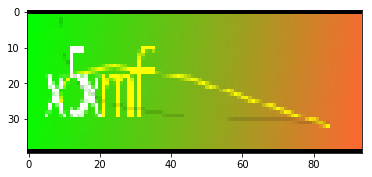

true: x5xmf | predicted: apvx


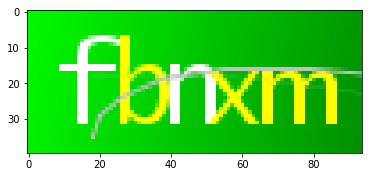

true: fbnxm | predicted: amlv1


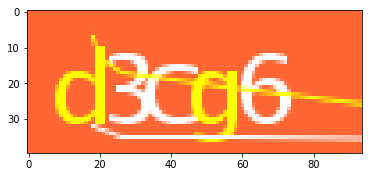

true: d3cg6 | predicted: 21lvf


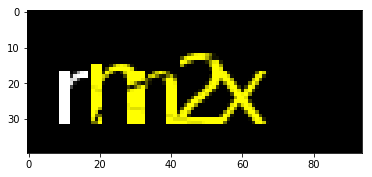

true: rnn2x | predicted: azpk


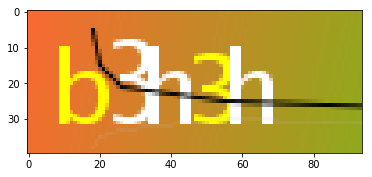

true: b3h3h | predicted: a1lvk


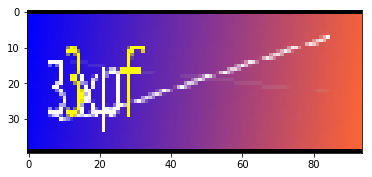

true: 33xpf | predicted: 2cpvk


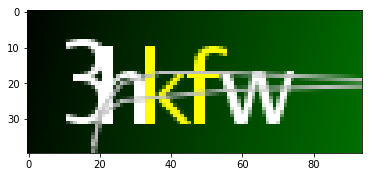

true: 3hkfw | predicted: aclvk


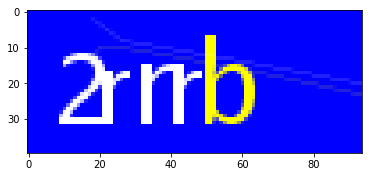

true: 2rrrb | predicted: 2cv1


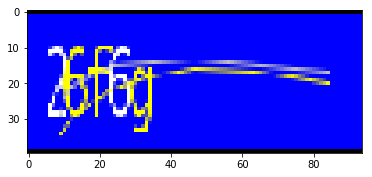

true: 26f6g | predicted: apvk


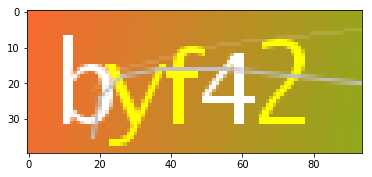

true: bym42 | predicted: apvk


In [47]:
#show some results
def testCaptcha(index):
    raw_img = X[index]
    true_label = y[index]
    
    X_test = np.zeros((1, height, width, 3), dtype = np.float32)
    X_test[0] = image.img_to_array(raw_img)
    
    result = model.predict(X_test)
    
    vex_test = vec_to_captcha(result[0])
    true_test = vec_to_captcha(true_label)
    
    plt.imshow(raw_img)
    plt.show()
    
    print("true:",true_test,"| predicted:",vex_test)
    

for i in range(30):
    testCaptcha(i)

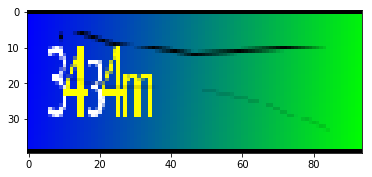

3n
[[0.         0.         0.9911014  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.

In [38]:
# single test
raw_img = image.load_img('/home/yan/jupyter notebooks/train_dir/3434m.png', target_size=(height, width))

X_test = np.zeros((1, height, width, 3), dtype = np.float32)
X_test[0] = image.img_to_array(raw_img)
result = model.predict(X_test)

vex_test = vec_to_captcha(result[0])
plt.imshow(raw_img)
plt.show()

print (vex_test)
print (result)